In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import torchvision
torch.manual_seed(0) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline

## 1. THE MNIST DATASET

In [2]:
path_data = './data/'
print("Will download MNIST Dataset to folder:", path_data)
mnist_dataset = torchvision.datasets.MNIST(root=path_data, download=True, transform=transforms.ToTensor()) 
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)
dataiter = iter(dataloader)

Will download MNIST Dataset to folder: ./data/


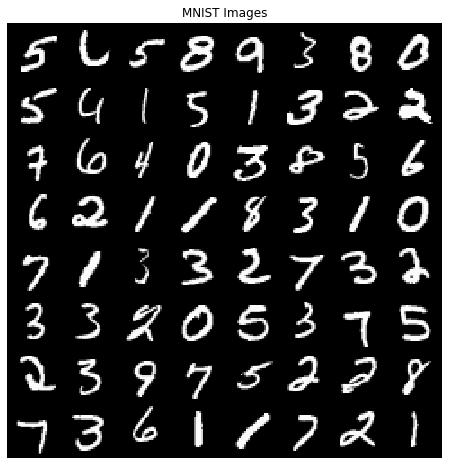

In [3]:
real_batch = next(dataiter)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("MNIST Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## 2. Building the Generator

In [4]:
def get_generator_block(input_dim: int, output_dim: int):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )


class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is the default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
        
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    

In [5]:
# Needed as Input by the Generator to generate Images
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.Tensor(np.random.normal(0, 1, (n_samples, z_dim))).to(device)

## 3. Building the Discriminator

In [6]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )


class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    

# 4. Define the Loss

In [7]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    # Create noise vectors and generate a batch (num_images) of fake images. 
    z = get_noise(num_images, z_dim, device)
    gen_imgs = gen(z)
    
    # detach the generator!
    for param in gen.parameters():
        param.requires_grad = False
    
    # Step 2: Get the discriminator's prediction of the fake image and calculate loss
    disc_fake_pred = disc(gen_imgs)
    fakes_gt = torch.zeros_like(disc_fake_pred)
    loss_disc_fake = criterion(disc_fake_pred, fakes_gt)
    
    # Step 3: Get the discriminator's prediction of the real image and calculate loss
    disc_real_pred = disc(real)
    reals_gt = torch.ones_like(disc_real_pred)
    loss_disc_real = criterion(disc_real_pred, reals_gt)
    
    # Step 4: The discriminator loss is the average between the real and fake loss
    disc_loss = (loss_disc_real + loss_disc_fake) / 2
    
    return disc_loss


def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    # Step 1: Generate fake images
    z = get_noise(num_images, z_dim, device)
    gen_imgs = gen(z)
    
    # Step 2: discriminator's prediction of the fake image.
    disc_fake_pred = disc(gen_imgs)
    
    # Step 3: Calculate the generator's loss
    fakes_gt_inverted = torch.ones_like(disc_fake_pred)
    # The goal of the generator is to make the discriminator thinks the fakes are real
    gen_loss = criterion(disc_fake_pred, fakes_gt_inverted)
    
    return gen_loss

# 5. Training

In [8]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [9]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200  # Number of Epochs to Train
z_dim = 64  # Dimension of Noise Vector
display_step = 5000  # Show intermediary results after n steps
batch_size = 128
lr = 0.00001

In [10]:
# Set optimizers
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Step 0: Generator loss: 0.00014604654312133788, discriminator loss: 0.00013765201568603517


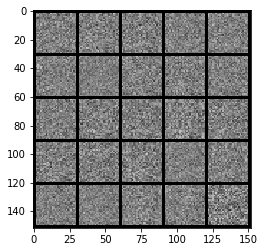

Step 5000: Generator loss: 2.241683793997761, discriminator loss: 0.17789183374717865


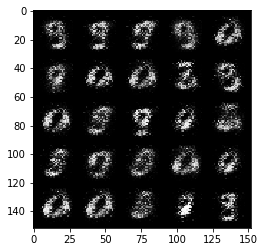

Step 10000: Generator loss: 3.901380573415755, discriminator loss: 0.07394301325343555


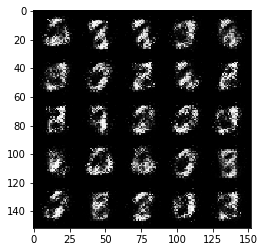

Step 15000: Generator loss: 3.985494473600376, discriminator loss: 0.08502785020209852


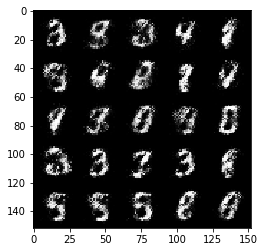

Step 20000: Generator loss: 3.372216685867298, discriminator loss: 0.14012032567933194


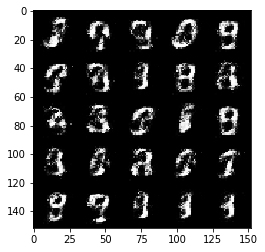

Step 25000: Generator loss: 2.989949907064446, discriminator loss: 0.19150940190851654


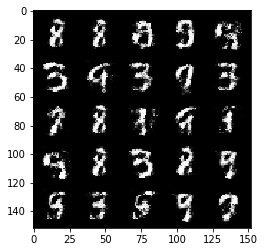

Step 30000: Generator loss: 2.6854118438482315, discriminator loss: 0.23436133779138393


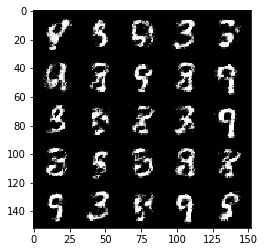

Step 35000: Generator loss: 2.496430280613906, discriminator loss: 0.2583223832115533


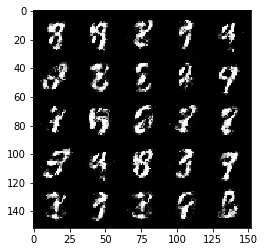

Step 40000: Generator loss: 2.276180899834632, discriminator loss: 0.2925652097895743


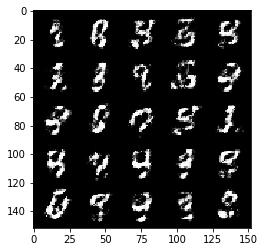

Step 45000: Generator loss: 2.0999293965816537, discriminator loss: 0.3166767945557839


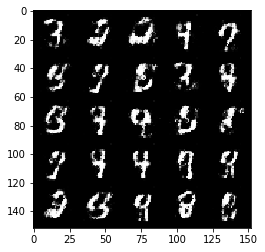

Step 50000: Generator loss: 1.9596526805877745, discriminator loss: 0.33648549730181704


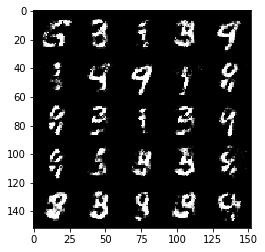

Step 55000: Generator loss: 1.864189971542361, discriminator loss: 0.3567352768719197


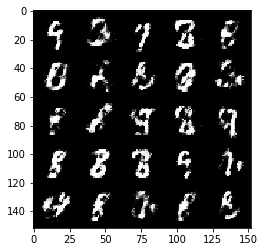

Step 60000: Generator loss: 1.7497774325609194, discriminator loss: 0.38312976356148604


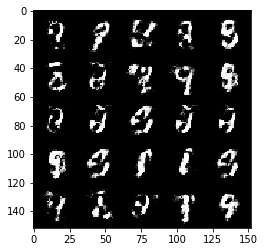

Step 65000: Generator loss: 1.7099006865263033, discriminator loss: 0.3876131309837108


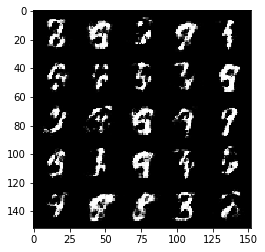

Step 70000: Generator loss: 1.6123090702533738, discriminator loss: 0.4088893643379203


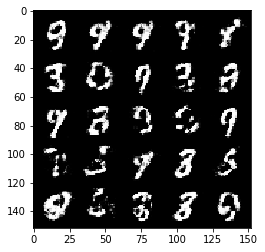

Step 75000: Generator loss: 1.5183990870952602, discriminator loss: 0.4403417371571081


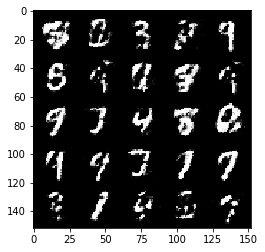

Step 80000: Generator loss: 1.4556548774480815, discriminator loss: 0.45154743551015725


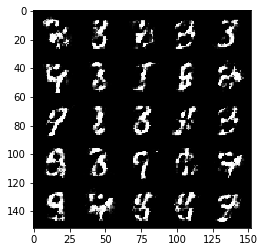

Step 85000: Generator loss: 1.4033424246430397, discriminator loss: 0.4628617069303984


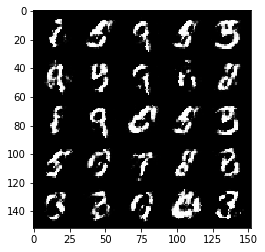

Step 90000: Generator loss: 1.3386762628436117, discriminator loss: 0.48047932838797636


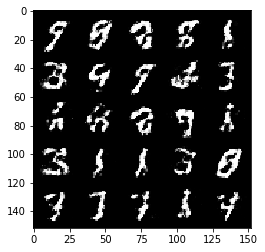

Step 95000: Generator loss: 1.3218588183879865, discriminator loss: 0.4844661257207404


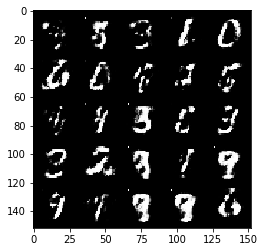

Step 100000: Generator loss: 1.2249134381175024, discriminator loss: 0.5185686408817762


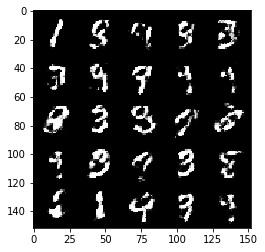

Step 105000: Generator loss: 1.2049401172757168, discriminator loss: 0.51608784957528


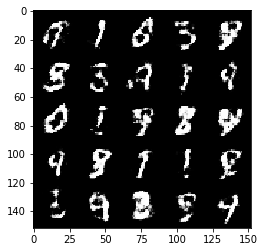

Step 110000: Generator loss: 1.135743689382079, discriminator loss: 0.5389820871710757


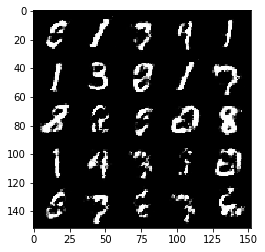

Step 115000: Generator loss: 1.0864596477985402, discriminator loss: 0.5519398316740987


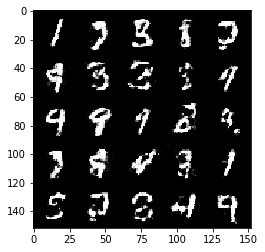

Step 120000: Generator loss: 1.0797897853970537, discriminator loss: 0.5517084021627918


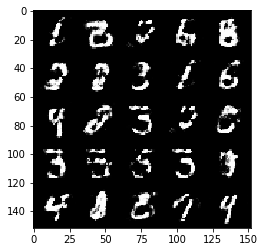

Step 125000: Generator loss: 1.0123799804091445, discriminator loss: 0.5794222307264805


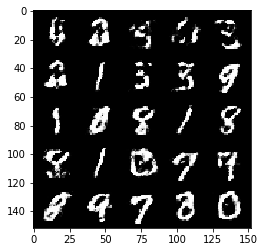

Step 130000: Generator loss: 1.0146295647382737, discriminator loss: 0.5754924099087712


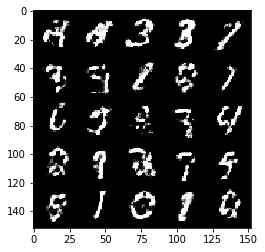

Step 135000: Generator loss: 0.9872158088684087, discriminator loss: 0.5849916974127275


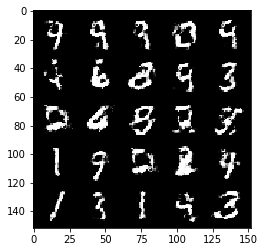

Step 140000: Generator loss: 0.9881384488224972, discriminator loss: 0.5844331827104099


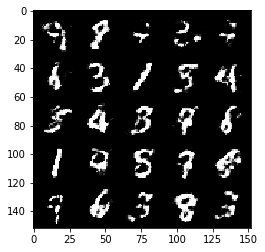

Step 145000: Generator loss: 0.9285237915992752, discriminator loss: 0.6052432031750683


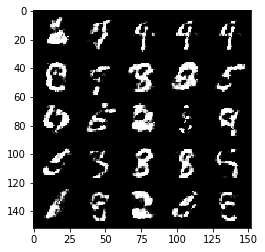

Step 150000: Generator loss: 0.932788725364209, discriminator loss: 0.6035380655527116


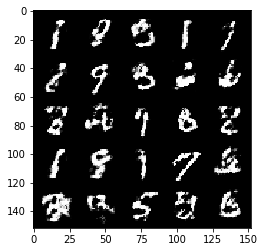

Step 155000: Generator loss: 0.9326145113706625, discriminator loss: 0.5968373621344578


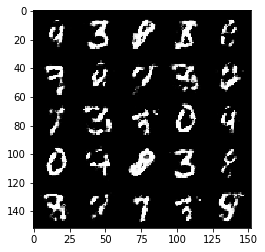

Step 160000: Generator loss: 0.929106321799755, discriminator loss: 0.6010926046192643


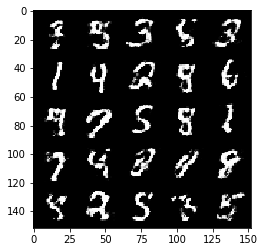

Step 165000: Generator loss: 0.916017000877856, discriminator loss: 0.6065183277726174


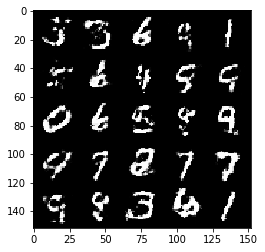

Step 170000: Generator loss: 0.9134441882371895, discriminator loss: 0.6059613625466816


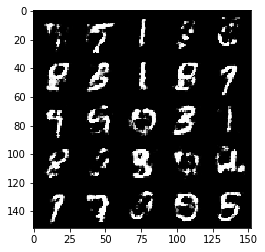

Step 175000: Generator loss: 0.9161953477621062, discriminator loss: 0.6023855636119849


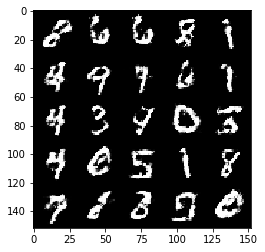

Step 180000: Generator loss: 0.9151935504794101, discriminator loss: 0.6020033797442904


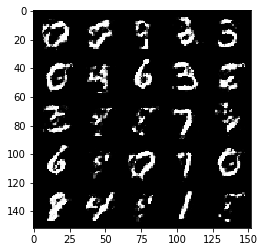

Step 185000: Generator loss: 0.8750773107171036, discriminator loss: 0.6195949228286736


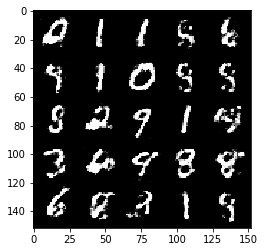

In [11]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False

disc_losses = []
gen_losses = []

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in dataloader:
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_losses.append(disc_loss.item())

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ### Update generator ###
        # Calculate the generator loss and update gradients
        for param in gen.parameters():
            param.requires_grad = True
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        gen_losses.append(gen_loss.item())

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

# 6. Plot Loss

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['font.size'] = 15
mpl.rcParams['figure.figsize'] = (20, 12)
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.autolayout'] = True

In [13]:
losses = disc_losses + gen_losses
models = ["Discriminator" for _ in disc_losses] + ["Generator" for _ in gen_losses]
steps = list(range(len(disc_losses))) + list(range(len(gen_losses)))
df = pd.DataFrame({"Model":models, "Loss":losses, "Step":steps})

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


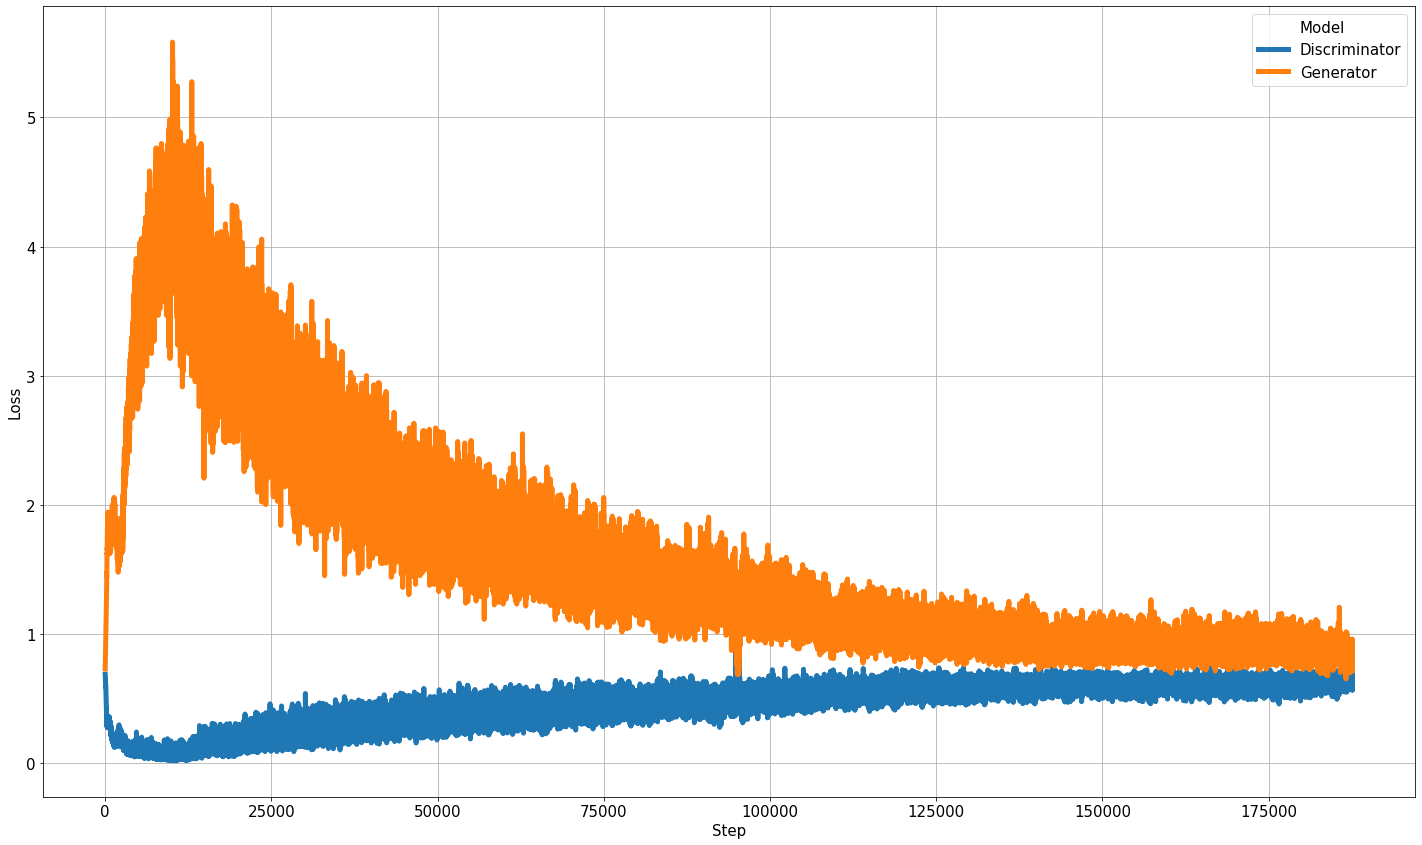

In [15]:
sns.lineplot(data=df, x="Step", y="Loss", hue="Model")
plt.grid()

In [16]:
print("Done")

Done
